In [10]:
import matplotlib.pyplot as plt
from cycler import cycler

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)] 
for i in range(len(tableau20)):
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)
    
plt.rc('legend', frameon=True,fancybox=True,fontsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('grid', linestyle="--", color='grey',alpha = 0.2)
plt.rc('font', size=14, family='sans-serif',style='normal',weight='normal')
plt.rc('axes', labelsize=14, titlesize=14,
       titleweight='bold',prop_cycle=(cycler('color',tableau20)))

plt.rc('figure', figsize=(14, 8),titlesize=16)

In [47]:
import pandas as pd
import numpy as np
import datetime
import os
%matplotlib inline

import matplotlib as mpl

In [48]:
df = pd.read_pickle(os.path.join('data','quote=OMXS30&start=2011-10-10&end=2017-10-09&interval=1440min.pkl'))
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1485 entries, 0 to 1484
Data columns (total 7 columns):
datetime    1485 non-null datetime64[ns]
stock       1485 non-null object
open        1485 non-null float64
high        1485 non-null float64
low         1485 non-null float64
close       1485 non-null float64
volume      1485 non-null float64
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 81.3+ KB


,datetime,stock,open,high,low,close,volume
0,2011-10-10 22:00:00,OMXS30,925.014320,948.294078,921.049615,948.294078,0.0
1,2011-10-11 22:00:00,OMXS30,947.375798,952.212159,937.354537,946.783556,0.0
2,2011-10-12 22:00:00,OMXS30,943.796878,960.695695,933.507326,957.743383,0.0
3,2011-10-13 22:00:00,OMXS30,954.842203,965.446404,933.353241,936.224381,0.0
4,2011-10-14 22:00:00,OMXS30,940.079858,959.668531,936.803331,956.394709,0.0


,open,high,low,close,volume
datetime,,,,,
2011-10-10 22:00:00,925.014320,948.294078,921.049615,948.294078,0.0
2011-10-11 22:00:00,947.375798,952.212159,937.354537,946.783556,0.0
2011-10-12 22:00:00,943.796878,960.695695,933.507326,957.743383,0.0
2011-10-13 22:00:00,954.842203,965.446404,933.353241,936.224381,0.0
2011-10-14 22:00:00,940.079858,959.668531,936.803331,956.394709,0.0


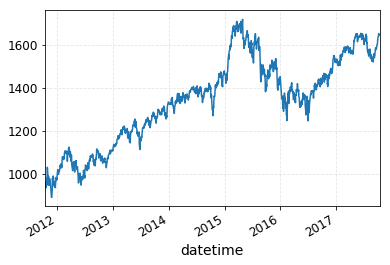

In [49]:
df = df.groupby(['datetime']).sum()
df['close'].plot(grid=True)
df.head()

In [50]:
# ADD MEASURES

df = df.join(df['high'].div(df['low'])
                         .sub(1).mul(100).rename('x_low_high'))
df = df.join(df['high'].div(df['open'])
                         .sub(1).mul(100).rename('x_open_high'))
# SHIFT SINGLE
# open/close.shift(1) = GAP
# close/close.shift(1) = GAP + DAY CHANGE (WHAT YOU SEE)
df = df.join(df['open'].div(df['close'].shift(periods=1))
                         .sub(1).mul(100).rename('x_close_open'))

for days in np.arange(1,11):
    # look at at days back total change
    df = df.join(df['open'].div(df['open'].shift(periods=days))
                             .sub(1).mul(100).rename('x_open_open_days_'+str(days)))
    # Look at days back daily change
    df = df.join(df['open'].shift(periods=days-1).div(df['open'].shift(periods=days))
                             .sub(1).mul(100).rename('x_open_open_day_'+str(days)))
    
#PREDICTORS, SHIFT BOTH BACK IN TIME, SEE IN FUTURE
#GAP FIRST DAY EXCLUDED SINCE CLOSE PRICE INCLUDED IN X (NO TIME TO TRADE)
# close.shift(-1)/open.shift(1) = NEXT DAY OUTCOME
# close.shift(-days)/open.shift(1) = NEXT X DAYS OUTCOME

for days in np.arange(0,11):
    df = df.join(df['close'].shift(periods=-days).div(df['open'])
                             .sub(1).mul(100).rename('y_open_close_days_'+str(days)))
    
df.head()

,open,high,low,close,volume,x_low_high,x_open_high,x_close_open,x_open_open_days_1,x_open_open_day_1,...,y_open_close_days_1,y_open_close_days_2,y_open_close_days_3,y_open_close_days_4,y_open_close_days_5,y_open_close_days_6,y_open_close_days_7,y_open_close_days_8,y_open_close_days_9,y_open_close_days_10
datetime,,,,,,,,,,,,,,,,,,,,,
2011-10-10 22:00:00,925.014320,948.294078,921.049615,948.294078,0.0,2.957980,2.516692,NaN,NaN,NaN,...,2.353394,3.538222,1.211880,3.392422,1.555288,2.217671,1.859901,0.976567,4.343961,5.736549
2011-10-11 22:00:00,947.375798,952.212159,937.354537,946.783556,0.0,1.585059,0.510501,-0.096835,2.417420,2.417420,...,1.094348,-1.177085,0.951989,-0.841783,-0.195034,-0.544359,-1.406844,1.881068,3.240786,2.986447
2011-10-12 22:00:00,943.796878,960.695695,933.507326,957.743383,0.0,2.912497,1.790514,-0.315455,-0.377772,-0.377772,...,-0.802344,1.334803,-0.465770,0.183431,-0.167219,-1.032974,2.267405,3.632279,3.376976,4.162147
2011-10-13 22:00:00,954.842203,965.446404,933.353241,936.224381,0.0,3.438480,1.110571,-0.302918,1.170307,1.170307,...,0.162593,-1.617152,-0.975461,-1.322054,-2.177795,1.084407,2.433493,2.181142,2.957231,7.802203
2011-10-14 22:00:00,940.079858,959.668531,936.803331,956.394709,0.0,2.440768,2.083724,0.411811,-1.546051,-1.546051,...,-0.072218,0.579550,0.227514,-0.641664,2.671764,4.042035,3.785722,4.573998,9.495052,9.110203


In [51]:
# ADD CAT INSTEAD OF FLOAT
df = df.join(df['x_open_open_day_1'].rename('x_open_open_day_1_up'))

mask = df['x_open_open_day_1'] < 0
df.loc[df['x_open_open_day_1'][mask].index,'x_open_open_day_1_up'] = False
mask = df['x_open_open_day_1'] > 0
df.loc[df['x_open_open_day_1'][mask].index,'x_open_open_day_1_up'] = True
df.head()

,open,high,low,close,volume,x_low_high,x_open_high,x_close_open,x_open_open_days_1,x_open_open_day_1,...,y_open_close_days_2,y_open_close_days_3,y_open_close_days_4,y_open_close_days_5,y_open_close_days_6,y_open_close_days_7,y_open_close_days_8,y_open_close_days_9,y_open_close_days_10,x_open_open_day_1_up
datetime,,,,,,,,,,,,,,,,,,,,,
2011-10-10 22:00:00,925.014320,948.294078,921.049615,948.294078,0.0,2.957980,2.516692,NaN,NaN,NaN,...,3.538222,1.211880,3.392422,1.555288,2.217671,1.859901,0.976567,4.343961,5.736549,NaN
2011-10-11 22:00:00,947.375798,952.212159,937.354537,946.783556,0.0,1.585059,0.510501,-0.096835,2.417420,2.417420,...,-1.177085,0.951989,-0.841783,-0.195034,-0.544359,-1.406844,1.881068,3.240786,2.986447,True
2011-10-12 22:00:00,943.796878,960.695695,933.507326,957.743383,0.0,2.912497,1.790514,-0.315455,-0.377772,-0.377772,...,1.334803,-0.465770,0.183431,-0.167219,-1.032974,2.267405,3.632279,3.376976,4.162147,False
2011-10-13 22:00:00,954.842203,965.446404,933.353241,936.224381,0.0,3.438480,1.110571,-0.302918,1.170307,1.170307,...,-1.617152,-0.975461,-1.322054,-2.177795,1.084407,2.433493,2.181142,2.957231,7.802203,True
2011-10-14 22:00:00,940.079858,959.668531,936.803331,956.394709,0.0,2.440768,2.083724,0.411811,-1.546051,-1.546051,...,0.579550,0.227514,-0.641664,2.671764,4.042035,3.785722,4.573998,9.495052,9.110203,False


In [52]:
# ADD CAT INSTEAD OF FLOAT
df = df.join(df['y_open_close_days_0'].rename('y_open_close_days_0_up'))

mask = df['y_open_close_days_0'] < 0
df.loc[df['y_open_close_days_0'][mask].index,'y_open_close_days_0_up'] = 0
mask = df['y_open_close_days_0'] > 0
df.loc[df['y_open_close_days_0'][mask].index,'y_open_close_days_0_up'] = 1
df.head()

,open,high,low,close,volume,x_low_high,x_open_high,x_close_open,x_open_open_days_1,x_open_open_day_1,...,y_open_close_days_3,y_open_close_days_4,y_open_close_days_5,y_open_close_days_6,y_open_close_days_7,y_open_close_days_8,y_open_close_days_9,y_open_close_days_10,x_open_open_day_1_up,y_open_close_days_0_up
datetime,,,,,,,,,,,,,,,,,,,,,
2011-10-10 22:00:00,925.014320,948.294078,921.049615,948.294078,0.0,2.957980,2.516692,NaN,NaN,NaN,...,1.211880,3.392422,1.555288,2.217671,1.859901,0.976567,4.343961,5.736549,NaN,1.0
2011-10-11 22:00:00,947.375798,952.212159,937.354537,946.783556,0.0,1.585059,0.510501,-0.096835,2.417420,2.417420,...,0.951989,-0.841783,-0.195034,-0.544359,-1.406844,1.881068,3.240786,2.986447,True,0.0
2011-10-12 22:00:00,943.796878,960.695695,933.507326,957.743383,0.0,2.912497,1.790514,-0.315455,-0.377772,-0.377772,...,-0.465770,0.183431,-0.167219,-1.032974,2.267405,3.632279,3.376976,4.162147,False,1.0
2011-10-13 22:00:00,954.842203,965.446404,933.353241,936.224381,0.0,3.438480,1.110571,-0.302918,1.170307,1.170307,...,-0.975461,-1.322054,-2.177795,1.084407,2.433493,2.181142,2.957231,7.802203,True,0.0
2011-10-14 22:00:00,940.079858,959.668531,936.803331,956.394709,0.0,2.440768,2.083724,0.411811,-1.546051,-1.546051,...,0.227514,-0.641664,2.671764,4.042035,3.785722,4.573998,9.495052,9.110203,False,1.0


In [53]:

df['x_open_open_day_1_streak'] = df['x_open_open_day_1_up']
up_days = 0
down_days = 0

for idx, value in df['x_open_open_day_1_streak'].iteritems():
    if value==False:
        down_days = down_days-1
        up_days = 0
        df.set_value(idx,'x_open_open_day_1_streak',down_days)
    elif value==True:
        up_days = up_days+1
        down_days = 0
        df.set_value(idx,'x_open_open_day_1_streak',up_days)
    else:
        df.set_value(idx,'x_open_open_day_1_streak',0)
        down_days = 0
        up_days = 0

df[['x_open_open_day_1','x_open_open_day_1_streak']].head()

,x_open_open_day_1,x_open_open_day_1_streak
datetime,,
2011-10-10 22:00:00,NaN,0
2011-10-11 22:00:00,2.417420,1
2011-10-12 22:00:00,-0.377772,-1
2011-10-13 22:00:00,1.170307,1
2011-10-14 22:00:00,-1.546051,-1


In [8]:
agg = {'count','mean'}
df[['y_open_close_days_0','x_open_open_day_1_streak']].replace([np.inf,-np.inf],np.nan).dropna().groupby('x_open_open_day_1_streak').agg(agg)

y_open_close_days_0          
                                       count      mean
x_open_open_day_1_streak                              
-7                                         1  0.229347
-6                                         7  0.915621
-5                                        20  0.003921
-4                                        33 -0.195784
-3                                        73  0.179202
-2                                       167  0.048919
-1                                       382  0.019236
 0                                         1  2.516692
 1                                       382 -0.037663
 2                                       197 -0.038574
 3                                       103  0.108786
 4                                        59 -0.057772
 5                                        28  0.170693
 6                                        17  0.030511
 7                                         6  0.089902
 8                                         3 -0.249289
 9                                         1  0.790121
 10                                        1  0.172983
 11                                        1  0.519639
 12                                        1  0.115953
 13                                        1  0.124914
 14                                        1 -0.415795

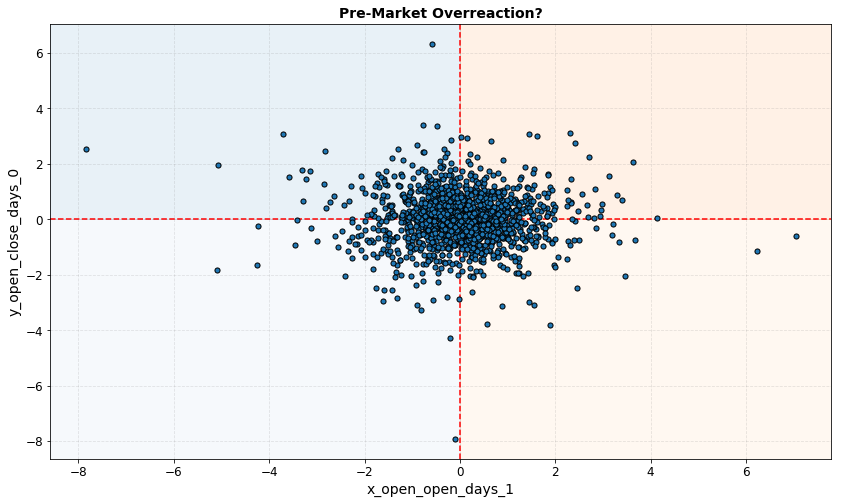

In [16]:
#df_stock_swap = df_stock.swaplevel(axis=1)
import matplotlib.patches as patches
# Close price change dependancy
f, ax = plt.subplots(1,1)
x = 'x_open_open_days_1'
y = 'y_open_close_days_0'

    #print('Neg:',df_sel[df_sel[x]<0][y].replace(np.inf,np.nan).dropna().mean())
    #print('Pos:',df_sel[df_sel[x]>0][y].replace(np.inf,np.nan).dropna().mean())
df.plot(ax=ax,kind='scatter',x=x,y=y,grid=True,s=26,edgecolor='black',legend=False,zorder=3)
#ax.legend(stocks)
ax.set_title('Pre-Market Overreaction?')
ax.axhline(0,ls = '--',color='red')
ax.axvline(0,ls = '--',color='red')
#ax.set_xlim([-10,10])
#plt.axvline(-1,ls='--',color='r')
#ax.axvspan(xmin=-10,xmax=0,alpha = 0.1,zorder=1)
for nr,x,y in zip([0,1,2,3],[-10,-10,0,0],[0,-10,0,-10]):
    ax.add_patch(
        patches.Rectangle(
            (x,y),   # (x,y)
            10,          # width
            10,          # height
            alpha = 0.1,
            color = tableau20[nr]
            ))

#ax.text(-7,7,'Open [-]\nClose [+]\nOverreaction during Pre-Market?')
#ax.text(-7,-7,'Open [-]\nClose [-]\nDecline continues during the day?')
#ax.text(3,7,'Open [+]\nClose [+]\nIncrease continues during the day')
#ax.text(3,-7,'Open [+]\nClose [-]\nGood morning, bad day')
#ax.set_xlim([-3,3])
#ax.set_ylim([-6,6])
#f.savefig('fig/overreaction.png', dpi=100,bbox_inches='tight')

In [18]:
def set_daily_xticks(df_date,ax,rot=0):
    major_ticks = pd.to_datetime(df_date.index.unique())
    major_tick_labels = list(map(lambda x: x.strftime('%a'), major_ticks))

    minor_ticks = list(filter(lambda x: x.dayofweek == 0, major_ticks))
    minor_tick_labels = list(map(lambda x: x.week, minor_ticks))

    ax.set_xticks(major_ticks, minor=False)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_xticklabels(major_tick_labels, minor=False, rotation=rot, ha='center',y=-0.03)
    ax.set_xticklabels(minor_tick_labels, minor=True, rotation=0, ha='center', weight='normal',alpha=1)
    
    ax.set_xlabel('')
    ax.grid()
    return ax

In [19]:
def add_measurement(df,x,m,ax,text=False,color='g'):
    y1 = df.loc[x[0]][m[0]]
    y2 = df.loc[x[1]][m[1]]
    if y2 < y1:
        text_color='r'
        color = 'r'
    else:
        text_color='g'
        color = 'g'
    d = {'datetime':x, text:[y1,y2]}
    df = pd.DataFrame(data=d).set_index('datetime')
    df.plot(marker='o', linestyle=':', color=color,ax=ax, legend=False,ms=6,alpha=1,lw=1)
    if text:
        text = str(round((y2/y1-1)*100,1))+'%'
        days = (x[1]-x[0]).days
        x_text = x[1]-pd.DateOffset(days=days/2)
        y_text = (y2+y1)/2
        ax.text(x_text, y_text, text,ha="center", va="center", color=text_color, bbox=dict(facecolor='white',
                                                                                           ec=color,ls=':'))
    return ax

10
2017-06-16 22:00:00 2017-06-19 22:00:00
datetime
2017-06-19 22:00:00    1636.78335
Name: You, dtype: float64


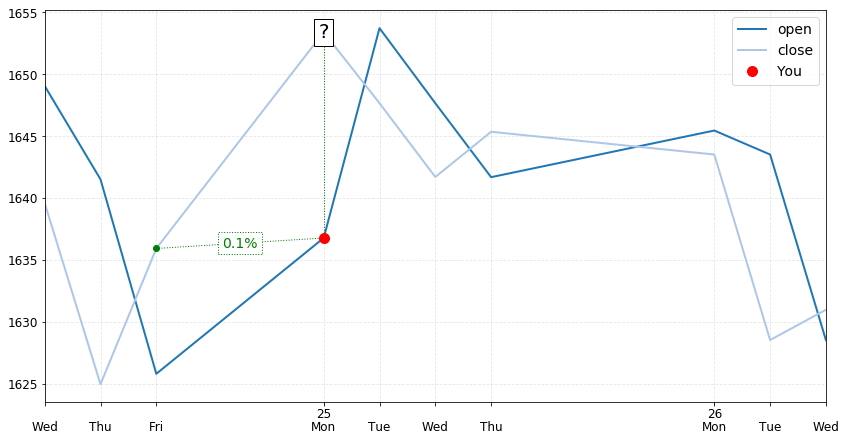

In [24]:

days = 15
start_date = pd.to_datetime('2017-06-14')
df_sel = df[(df.index < start_date+pd.DateOffset(days=days)) &
                       (df.index >= start_date)][['open','close','high','low']]

days = df_sel.shape[0]
print(days)
f, ax = plt.subplots(1,1)
df_sel[['open','close']].plot(lw=2,ax=ax)
d_day = 3
HIST = True
PRED = True
if HIST:
    for i in np.arange(d_day-1,d_day):
        x1 = df_sel.index[i]; x2 = df_sel.index[i+1]
        print(x1,x2)
        df_sel.pipe(add_measurement,x=[x1,x2],m=['close','open'],ax=ax,color='y',text=True)
        #x1 = df_sel.index[i]; x2 = df_sel.index[i]
        #df_sel.pipe(add_measurement,x=[x1,x2],m=['open','close'],ax=ax,color='y',text=True)
if PRED:
    for i in np.arange(d_day,d_day+1):
        x1 = df_sel.index[d_day]; x2 = df_sel.index[i]
        df_sel.pipe(add_measurement,x=[x1,x2],m=['open','close'],ax=ax,color='orange')

# YOU
df_sel.iloc[[d_day]]['open'].rename('You').plot(marker='o', linestyle='none', color='r',ax=ax, legend=True ,
                                                ms=10,alpha=1,lw=1)
# QUESTIONMARK
offset = 0
ax.text(x=df_sel.index[d_day+offset], y=df_sel.loc[df_sel.index[d_day+offset]]['close'], s='?',size=20,ha="center",
        va="center", bbox=dict(facecolor='white',ls='-'))

set_daily_xticks(df_sel,ax)
print(df_sel.iloc[[d_day]]['open'].rename('You'))
f.savefig('fig/'+stock+'-'+str(days)+'-hist-'+str(HIST)+'-pred-'+str(PRED)+'.png', dpi=100,bbox_inches='tight')

In [60]:
df = df.dropna()

x_var = [x for x in np.unique(df.columns) if 'x_' in x]
print(x_var)

df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75
train, test = df[df['is_train']==True], df[df['is_train']==False]
x_train = train[x_var].values
y_train = train['y_open_close_days_0_up'].values
x_test = test[x_var].values
y_test = test['y_open_close_days_0_up'].values

x_combined = np.concatenate((x_train,x_test))
y_combined = np.concatenate((y_train,y_test))


['x_close_open', 'x_low_high', 'x_open_high', 'x_open_open_day_1', 'x_open_open_day_10', 'x_open_open_day_1_streak', 'x_open_open_day_1_up', 'x_open_open_day_2', 'x_open_open_day_3', 'x_open_open_day_4', 'x_open_open_day_5', 'x_open_open_day_6', 'x_open_open_day_7', 'x_open_open_day_8', 'x_open_open_day_9', 'x_open_open_days_1', 'x_open_open_days_10', 'x_open_open_days_2', 'x_open_open_days_3', 'x_open_open_days_4', 'x_open_open_days_5', 'x_open_open_days_6', 'x_open_open_days_7', 'x_open_open_days_8', 'x_open_open_days_9']


In [63]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(max_depth=40)
gbc.fit(x_train, y_train)
score = gbc.score(x_test, y_test)
score

TypeError: 'numpy.ndarray' object is not callable

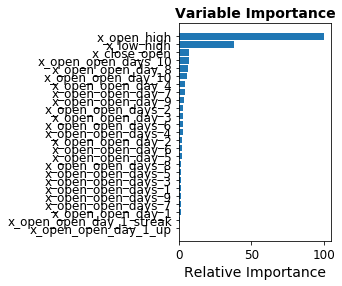

In [71]:
# Plot feature importance
feature_importance = gbc.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(x_var)[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [70]:
print(feature_importance)
print(x_var)

[  7.26182190e+00   3.77522517e+01   1.00000000e+02   1.15023717e+00
   5.67769361e+00   1.04906503e+00   1.66794808e-02   2.01115984e+00
   2.80529309e+00   3.98328574e+00   1.96529301e+00   2.00856560e+00
   3.97440295e+00   6.29782438e+00   3.56700210e+00   1.47229452e+00
   7.07245607e+00   2.82383704e+00   1.53272999e+00   2.70180150e+00
   1.55749633e+00   2.70561475e+00   1.22244370e+00   1.59954365e+00
   1.46858627e+00]
['x_close_open', 'x_low_high', 'x_open_high', 'x_open_open_day_1', 'x_open_open_day_10', 'x_open_open_day_1_streak', 'x_open_open_day_1_up', 'x_open_open_day_2', 'x_open_open_day_3', 'x_open_open_day_4', 'x_open_open_day_5', 'x_open_open_day_6', 'x_open_open_day_7', 'x_open_open_day_8', 'x_open_open_day_9', 'x_open_open_days_1', 'x_open_open_days_10', 'x_open_open_days_2', 'x_open_open_days_3', 'x_open_open_days_4', 'x_open_open_days_5', 'x_open_open_days_6', 'x_open_open_days_7', 'x_open_open_days_8', 'x_open_open_days_9']
